In [1]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

Let's clean our data up some. We will merge the Information, Publishers, and Developers csv's into a single dataframe, then get rid of our NaN entries, empty columns, and Free-to-Play games. This leaves us with ~1250 entries out of our original 2000.

In [2]:
publisherColumns = ['appid','publisher']
developerColumns = ['appid','developer']

#read in data, skip bad lines
appInformation = pd.read_csv('data/applicationInformation.csv',encoding='utf-8')
appDevelopers = pd.read_csv('data/applicationDevelopers.csv',encoding='utf-8',names=developerColumns,on_bad_lines='skip')
appPublishers = pd.read_csv('data/applicationPublishers.csv',encoding='utf-8',names=publisherColumns,on_bad_lines='skip')

#merge data
appMergedInfo = appInformation.merge(appDevelopers, on='appid').merge(appPublishers, on='appid')

#remove non-games, remove FTP, remove NaN, export to csv for checking
appMergedInfo = appMergedInfo[appMergedInfo['type'] == 'game']
appMergedInfo = appMergedInfo[appMergedInfo['freetoplay'] == 0] 
appMergedInfo.dropna(axis=0,how='any',inplace=True) 
appMergedInfo.to_csv('merged_info.csv',index=False) 

Now let's take our Player Count History csv's and normalize them to 1-day intervals so that we can easily plot/graph the features over time. Daily player counts are averaged over the whole day. The output for each Normalized Player Count History is in data/NormalizedPlayerCountHistory/{appid}.csv


NOTE: This cell takes up to 15-18 minutes to run in it's entirety. It processes and normalizes 2000 files so it takes a while. I was too lazy to parallelize the file processing.

In [3]:
#THIS TAKES A SUPER LONG TIME TO RUN, LIKE 16 MINS

# Directory paths for PlayerCountHistory
playerCountDir = ["data/PlayerCountHistoryPart1/","data/PlayerCountHistoryPart2/"]

# Loop through CSV files in the directory
nFiles = 0
for dir in playerCountDir:
    for filename in os.listdir(dir):
        if filename.endswith(".csv"):
            nFiles = nFiles+1
            filePath = os.path.join(dir, filename)
            appid = os.path.splitext(filename)[0]  # Extract the app id from the filename
            data = pd.read_csv(filePath, parse_dates=['Time'], index_col='Time')
            print(filePath) #for tracking status
            
            # Resample the data to 1-day intervals and calculate the daily average player count (int)
            dailyAveragePlayerCount = data.resample('1D').mean()
            dailyAveragePlayerCount['Playercount'] = dailyAveragePlayerCount['Playercount'].fillna(-1).astype(int)

            #store in new dataframe to rename "Time" column to "Date" (theres probably an easier way but this works)
            resultDF = pd.DataFrame({'Date': dailyAveragePlayerCount.index, 'Playercount': dailyAveragePlayerCount['Playercount']})

            # Store in CSV
            resultDF.to_csv(f"data/NormalizedPlayerCountHistory/{appid}.csv", index=False)
print(f"{nFiles}" + " csv files normalized to 1-day intervals with average players per day. Stored in NormalizedPlayerCountHistory. Organized by appid.")

data/PlayerCountHistoryPart1/350110.csv
data/PlayerCountHistoryPart1/442080.csv
data/PlayerCountHistoryPart1/599460.csv
data/PlayerCountHistoryPart1/513650.csv
data/PlayerCountHistoryPart1/639790.csv
data/PlayerCountHistoryPart1/468070.csv
data/PlayerCountHistoryPart1/501800.csv
data/PlayerCountHistoryPart1/466240.csv
data/PlayerCountHistoryPart1/612880.csv
data/PlayerCountHistoryPart1/382080.csv
data/PlayerCountHistoryPart1/314970.csv
data/PlayerCountHistoryPart1/681820.csv
data/PlayerCountHistoryPart1/378200.csv
data/PlayerCountHistoryPart1/533340.csv
data/PlayerCountHistoryPart1/465710.csv
data/PlayerCountHistoryPart1/32500.csv
data/PlayerCountHistoryPart1/3900.csv
data/PlayerCountHistoryPart1/551670.csv
data/PlayerCountHistoryPart1/319630.csv
data/PlayerCountHistoryPart1/238430.csv
data/PlayerCountHistoryPart1/368360.csv
data/PlayerCountHistoryPart1/370730.csv
data/PlayerCountHistoryPart1/460120.csv
data/PlayerCountHistoryPart1/296470.csv
data/PlayerCountHistoryPart1/58610.csv
data

Now let's go through each appid in our MergedInfo dataframe and for each of them, plot the price and player count over time to check for correlations. We can change the values plotted to see different features (will streamline this soon)


NOTE: Will take a very long time to generate every single graph, I have yet to run it in it's entirety

In [4]:
def delete_files_with_extension(directory, extension):
    for filename in os.listdir(directory):
        if filename.endswith(extension):
            file_path = os.path.join(directory, filename)
            os.remove(file_path)
            print(f"Deleted: {file_path}")

delete_files_with_extension("data/Graphs/",".jpeg")

counter = 0

#directories
countDirTemplate = "data/NormalizedPlayerCountHistory/"
priceDirTemplate = "data/PriceHistory/"

for appid in appMergedInfo['appid']:
    #convert appid to .csv string
    appid_string = str(appid) + ".csv"
    #build price & playercount directory paths
    countDir = os.path.join(countDirTemplate, appid_string)
    priceDir = os.path.join(priceDirTemplate, appid_string)
    #if both price and playercount exist, plot
    if os.path.exists(countDir) and os.path.exists(priceDir):
        countData = pd.read_csv(countDir)
        priceData = pd.read_csv(priceDir)
        mergedData = priceData.merge(countData, on='Date')
        print(mergedData)

        title = appMergedInfo.loc[appMergedInfo['appid'] == appid, 'name'].values[0]
        
        # Plot "Finalprice" vs "Playercount"
        fig, ax1 = plt.subplots(figsize=(10, 6))
        ax1.plot(mergedData['Date'], mergedData['Finalprice'], label='Finalprice', color='b')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Finalprice')
        
        ax2 = ax1.twinx()
        ax2.plot(mergedData['Date'], mergedData['Playercount'], label='Player Count', color='r')
        ax2.set_ylabel('Player Count')

        # Set labels and title
        plt.title('Finalprice vs Player Count Over Time for ' + title)

        # Configure x-axis date ticks on a monthly basis
        ax1.xaxis.set_major_locator(MaxNLocator(nbins=8))
        
        # Display the legend
        plt.legend(loc='upper left')

        # Save every 100th plot for visual analyzation, Comment this out to not be flooded with .jpegs
        if(counter%100 == 0):
            print("Saved Graph",str(appid))
            plt.savefig("data/Graphs/PlayerCountVsPrice/" + str(appid) + ".jpeg")
            plt.close()
        else:
            plt.close()

        counter = counter + 1

           Date  Initialprice  Finalprice  Discount  Playercount
0    2019-04-07         29.99       29.99         0       468782
1    2019-04-08         29.99       29.99         0       383311
2    2019-04-09         29.99       29.99         0       389990
3    2019-04-10         29.99       29.99         0       348582
4    2019-04-11         29.99       29.99         0       382034
..          ...           ...         ...       ...          ...
488  2020-08-08         29.99       29.99         0       217752
489  2020-08-09         29.99       29.99         0       220377
490  2020-08-10         29.99       29.99         0       191059
491  2020-08-11         29.99       29.99         0       187966
492  2020-08-12         29.99       29.99         0       188513

[493 rows x 5 columns]
Saved Graph 578080
           Date  Initialprice  Finalprice  Discount  Playercount
0    2019-04-07         19.99       10.99        45        79583
1    2019-04-08         19.99       19.99      

In this cell I am going to create and add new possibly useful features to our datasets (total # times gone on sale, average discount %, seasonality of discounts, etc) that we may want to use in our model

In [5]:
countDirTemplate = "data/NormalizedPlayerCountHistory/"
priceDirTemplate = "data/PriceHistory/"

#not worried abt free to play
#appMergedInfo.drop(columns=['freetoplay'], inplace=True)
#add new columns and initalize them
appMergedInfo['numberofsales'] = -1
appMergedInfo['averagediscount'] = -1

#function to get total sales (consecutive days of sales count as 1 'sale')
def get_total_sales(priceData):
    saleCount = 0
    onSale = False

    for i in range(len(priceData)):
        if priceData['Discount'][i] != 0 and not onSale:
            # Start of a new consecutive series of sale days
            saleCount += 1
            onSale = True
        elif priceData['Discount'][i] == 0:
            # End of the current consecutive series of sale days
            onSale = False

    return saleCount

#function to get average discount percentage
def get_average_discount(priceData):
    n = 0
    sum = 0

    for i in range(len(priceData)):
        n += 1
        if priceData['Discount'][i] != 0:
            sum += priceData['Discount'][i]
    avg = sum/n
    return avg
    
#go through each appid, use it to index into price/playercount history and generate new features to add to appMergedInfo
for appid in appMergedInfo['appid']:
    #convert appid to .csv string
    appid_string = str(appid) + ".csv"
    #build price & playercount directory paths
    countDir = os.path.join(countDirTemplate, appid_string)
    priceDir = os.path.join(priceDirTemplate, appid_string)
    if os.path.exists(countDir) and os.path.exists(priceDir):
        #read in data
        countData = pd.read_csv(countDir)
        priceData = pd.read_csv(priceDir)
        #get new feature values
        totalSales = get_total_sales(priceData)
        averageDiscount = get_average_discount(priceData)
        #assign new feature values
        appMergedInfo.loc[appMergedInfo['appid'] == appid, 'numberofsales'] = totalSales
        appMergedInfo.loc[appMergedInfo['appid'] == appid, 'averagediscount'] = averageDiscount
    
print(appMergedInfo)

       appid  type                            name releasedate  \
0     578080  game   PLAYERUNKNOWN'S BATTLEGROUNDS   21-Dec-17   
3     359550  game  Tom Clancy's Rainbow Six Siege    1-Dec-15   
4     271590  game              Grand Theft Auto V   13-Apr-15   
8     252950  game                   Rocket League    7-Jul-15   
9     252490  game                            Rust    8-Feb-18   
...      ...   ...                             ...         ...   
1732  562760  game                        KORABLIK   14-Feb-17   
1733  394690  game                     Tower Unite    8-Apr-16   
1734  227860  game                    Castle Story   17-Aug-17   
1737  429050  game             Feed and Grow: Fish    8-Jan-16   
1738  304730  game                     Train Fever    4-Sep-14   

              developer                    publisher  numberofsales  \
0      PUBG Corporation             PUBG Corporation              9   
3      Ubisoft Montreal                      Ubisoft             

Here I am going to merge the NormalizedPlayerCount csv's and the PriceHistory csv's into CombinedPricePlayerCountHistory

In [6]:
countDirTemplate = "data/NormalizedPlayerCountHistory/"
priceDirTemplate = "data/PriceHistory/"

for appid in appMergedInfo['appid']:
    #convert appid to .csv string
    appid_string = str(appid) + ".csv"
    #build price & playercount directory paths
    countDir = os.path.join(countDirTemplate, appid_string)
    priceDir = os.path.join(priceDirTemplate, appid_string)
    #if both price and playercount exist, merge, store in CombinedPricePlayerCountHistory
    if os.path.exists(countDir) and os.path.exists(priceDir):
        count_df = pd.read_csv(f"data/NormalizedPlayerCountHistory/{appid_string}")
        price_df = pd.read_csv(f"data/PriceHistory/{appid_string}")

        pricecount_df = count_df.merge(price_df, on='Date')
        pricecount_df['Date'] = pd.to_datetime(pricecount_df['Date'])
        pricecount_df.to_csv(f"data/CombinedPricePlayerCountHistory/{appid_string}", index=False)


I guess this is the part where we start applying actual machine learning techniques on our data in order to make predictions. My idea here is to start simple with something like a decision tree, then expand and try other techniques to see what is the most successful. We should also look into subsampling/oversampling to see if it can benefit our model.

In this cell I am going through each csv in CombinedPricePlayerCountHistory and creating a 2/3 train/test split on the dates based on the number of samples in the given csv. A csv must have at least 10 samples to be considered. This model does not consider the "final price" since i think that gives away whether or not there is a discount and how much it is. This model also works on an individual basis per csv and does not consider the grand scope of all the csv's when making decisions.

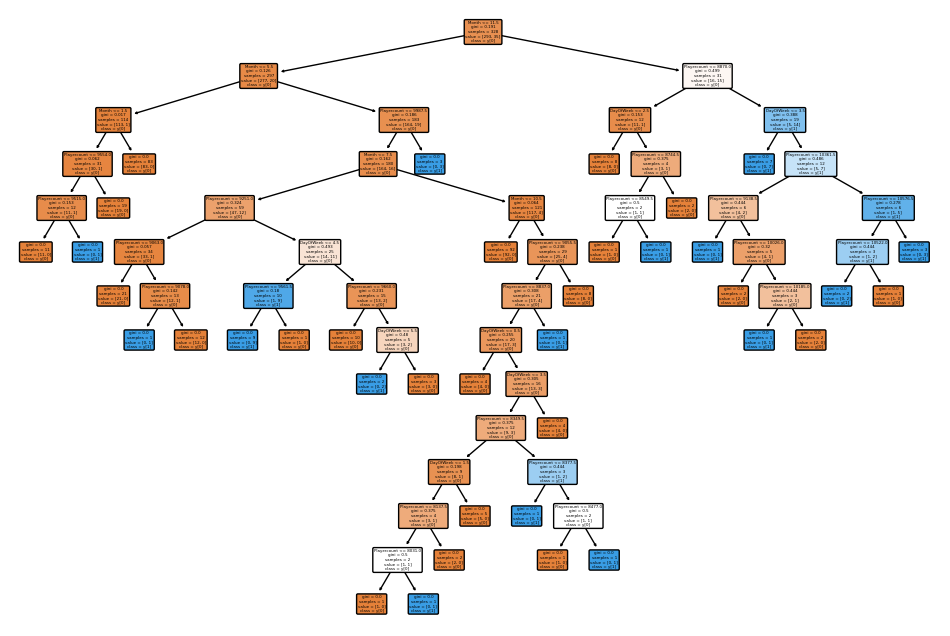

10.csv Accuracy: 0.5636363636363636


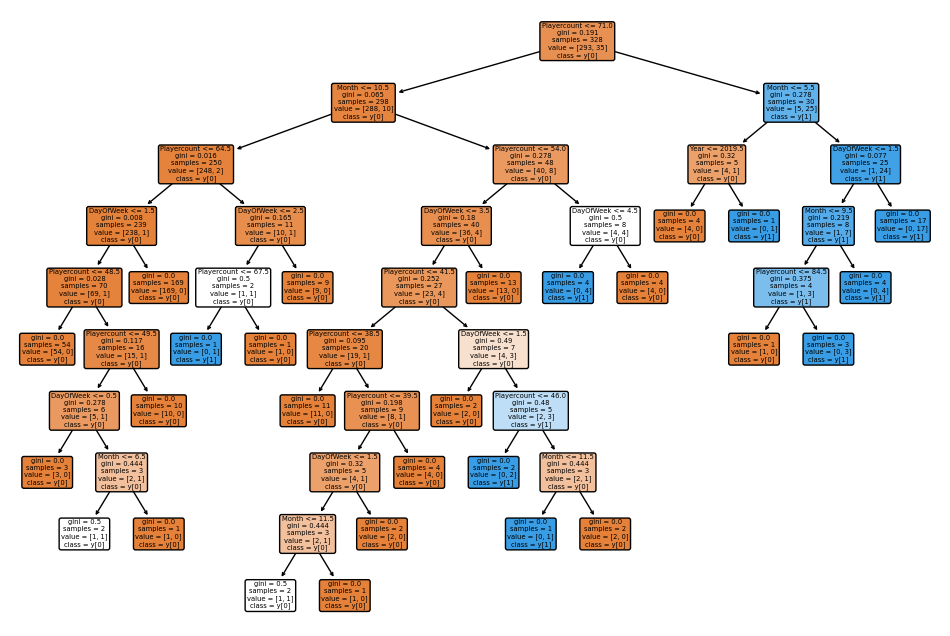

100.csv Accuracy: 0.6280487804878049


KeyboardInterrupt: 

In [6]:
#folder of csvs
folder = "data/CombinedPricePlayerCountHistory/"

#for calculating average accuracy
accuracy_sum = 0
accuracy_num = 0

#loop through csv's in folder
for filename in os.listdir(folder):
    if filename == "readme.md":
        continue
    fullpath = os.path.join(folder, filename)

    #read in csv, convert date column to datetime object
    example_df = pd.read_csv(fullpath)
    example_df['Date'] = pd.to_datetime(example_df['Date'])

    #get # samples, throw out entries with less than 10 samples
    samples = len(example_df)
    if samples < 10:
        continue

    #2/3 samples train/test split
    split = math.floor(samples * (2/3))

    #split at date 2/3 of the way through entry by using "split" to index into the df, get the date, and use that
    split_date = example_df.iloc[split]['Date']
    split_date = pd.to_datetime(split_date)
    train_data = example_df[example_df['Date'] < split_date]
    test_data = example_df[example_df['Date'] >= split_date]

    #Considering 'Finalprice' spoils whether or not there is a discount/it's amount so we omit that feature
    #Set up training data
    #X_train = train_data[['Date', 'Playercount', 'Initialprice','Finalprice']]
    X_train = train_data[['Date', 'Playercount', 'Initialprice']]
    y_train = train_data['Discount']

    #Set up testing data
    #X_test = test_data[['Date', 'Playercount', 'Initialprice','Finalprice']]
    X_test = test_data[['Date', 'Playercount', 'Initialprice']]
    y_test = test_data['Discount']

    #convert dates into something more compatible with our model (dates are not ML friendly)
    X_train['DayOfWeek'] = X_train['Date'].dt.dayofweek
    X_train['Month'] = X_train['Date'].dt.month
    X_train['Year'] = X_train['Date'].dt.year
    X_test['DayOfWeek'] = X_test['Date'].dt.dayofweek
    X_test['Month'] = X_test['Date'].dt.month
    X_test['Year'] = X_test['Date'].dt.year

    #drop the old date
    X_train = X_train.drop(['Date'], axis=1)
    X_test = X_test.drop(['Date'], axis=1)

    #fit classifier to training data
    model = DecisionTreeClassifier()
    model.fit(X_train, y_train)

    #make predictions on the test set
    predictions = model.predict(X_test)

    #evaluate/print the accuracy
    accuracy = accuracy_score(y_test, predictions)
    accuracy_sum += accuracy
    accuracy_num += 1
    print(f'{filename} Accuracy: {accuracy}')

#print average accuracy across all tests
accuracy_avg = accuracy_sum / accuracy_num
print(f'Average Accuracy: {accuracy_avg}')